<a href="https://colab.research.google.com/github/Coyote-Schmoyote/GAN-project/blob/main/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image generation with GAN
This notebook looks into the process of generating images using GAN. The first part of the notebook covers the workflow of building a simple GAN using an example of simple handwritten digit image generation. It is meant to serve as an introduction to the second part of the notebook, art portrait generation with DCGAN. The project is inspired by the AI-generated portrait of Edmond de Belamy (2018) that was sold at Christie's for $432,000. 
## 1. Problem Definition
Generate new images based on the input images from the dataset.
## 2. Data
The data used in this project is the Portrait Paintings dataset available on Kaggle (https://www.kaggle.com/datasets/deewakarchakraborty/portrait-paintings). The dataset consists of 5734 images of portrait paintings created between 1859 to 1950.
## 3. Approach
For this project, we will use Generative Adversarial Network (GAN) for MNIST digit generation, and Deep Convolutional Generative Adversarial Network (DCGAN) for art portrait generation.

##4. Evaluation
There is no function to evaluate the performance of a GAN model, which means that the performance of the model will be evaluated based on the quality of the generated images.

In [ ]:
import os
import numpy as np
import random 
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

#I. MNIST Digit Generation with GAN
## Generative Adversarial Network (GAN)
GAN is an unsupervised learning algorithm that discovers the patterns in the input data, and uses it to generate completely new data based on the input dataset. This deep learning architecture was introduced in 2014 by Ian Goodfellow and his colleagues, and is considered to be one of the most significant innovations in image generation. 

A simple GAN uses convolutional neural network (CNN), composed of convolutional layer with ReLU activation function, pooling layer, and fully connected Dense layers. 

Apart from simple GAN architecture, there are many variations, such as DCGAN, CycleGAN, PGGAN, StyleGAN, etc., each more suitable for a particular task. Despite their differences, all these architectures follow a similar basic structure based on convolutional neural networks, and apply two "competitive" (adversarial) models: a generator and a discriminator. 



## Data prepearation
For our first project with GAN, we will use MNIST handwritten digit dataset, which is conveniently built in `keras.datasets` module. 

First, we will need to import the module and load the train images. For this project, we don't need to import training labels (they correspond with the number depicted in the image for classification tasks, and we don't need them for image generation) and test dataset. To import only the trianing images, we will leave the `train_labels` and `test_images, test_labels` blank `(_, _)`.

In [ ]:
from keras.datasets.mnist import load_data

(train_images, _), (_, _) = load_data()

11501568/11490434 [==============================] - 0s 0us/step


**Shape** of data is a very important concept in deep learning. All data has shape, and shape has meaning. The shape of an image is usually represented in 3 dimensions: height, weight, and the number of color channels (if it's grayscale image, the color channel=1, and if it's an RGB image, the color channel=3). For example, if we have a color 64x64px image, its dimension will be represented as `[64, 64, 3]`. 

When we have a set of images as a tensor, the first dimension refers to the batch number, i.e. how many samples there are in the tensor. For example, if we have a batch of 1000 color images of 64x64px, the dimension will be represented as `[1000, 64, 64, 3]`.

Our `train_images` MNIST data is a tensor that has 60000 samples of size 28x28. 

In [ ]:
print("train", train_images.shape)

train (60000, 28, 28)


As we remember from our previous projects with image manipulation, `train_images` are not actual images, they are a numerical representation of an image in a form of an array. Each numerical value represents the brightness of a pixel.

* 0 represents the darkest value (black)
* 255 represents the brightest value (white)

Let's take a look at the first array of an image from our `train_images` variable.

In [ ]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

To display this an image, we can plot it using the `plt.imshow()`, and specify that we want to view it in grayscale by using `cmap = "gray"`.

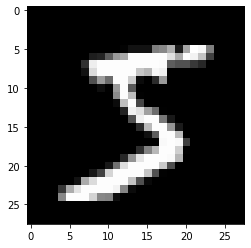

In [ ]:
# disaply a sample image
plt.imshow(train_images[0], cmap="gray");

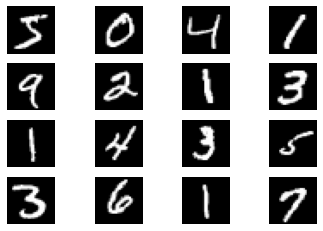

In [ ]:
# display multiple sample images
for i in range(16):
  plt.subplot(4, 4, 1+i)
  plt.axis("off")
  plt.imshow(train_images[i], cmap="gray")
plt.show()

## Generator and disrciminator
The main feature of a GAN model is the interaction between the generator and discriminator. The generator learns how to generate new handwritten digits using the examples from the training dataset. The role of the discriminator is then to decide whether the images are real (from the original dataset) or fake (created by the generator). If the discriminator guesses correctly, the generator algorithm adapts and tries to produce more realistic images. If the discriminator is wrong, it must adjust its algorithms to learn how to better distinguish real images from fake ones. 

### Discriminator
Discriminator is a CNN-based binary classification network, which attempts to guess whether the images are fake (0) or real (1). 
During the training, the Discriminator receives half of the images from the training dataset, and the other half of images from the Generator. It then attempts to predict whether an image comes from the original dataset or from the Generator.

Let's build the discriminator model using `keras.Sequential` module. We will use 5 types of layers:
* Conv2D
* LeakyReLU
* Dropout
* Flatten
* Dense

**Conv2D layer** creates a convolution filter (kernel) that slides over the 2D input data (image) and performs matrix multiplication. Convolutions decrease the image size and compress all the information by summing up the matrix multiplication results. The final output of the convolutional layer is a vector that is passed to the next layer.
Conv2D layer accepts multiple parameters, but the most important ones are the number of `filters`, `kernel_size`(or filter size), `strides`, and `padding`.
 * Number of filters: It is common for a convolutional layer to have from 32 to 512 filters. The higher the number of filters, the more complex features the network can extract from the image data. Often, we the value of the filter becomes higher as the network gets deeper.
 * `kernel_size` refers tothe size of the convolutional filter that slides over the image. There is no specific way to choose dimensions of a kernel size. Currently, the most popular choices for kernel size is 3x3, and there is a general preference for odd numbers (1x1, 3x3, 5x5), because, unlike even number filters (2x2, 4x4), they symmetrically divide the previous layer pixels around the centered output pixel.

**Leaky ReLU layer** is an activation function layer that follows the convolutional layer. Leaky ReLU is a leaky version of a Rectified Linear Unit (ReLU) activation function. Leaky ReLU is preferred in CNN because it solved the problem of dying ReLU, which prevents the neural network from learning.

**Dropout layer** is a typical layer used in Convolutional Neural Networks. The Dropout layer is a regularization method that is used to prevent overfitting of the training data. Without a Dropout layer, the first batch of training samples influences the learning process disporportionately. In the dropout layer, we randomly drop out some of the layer's neurons by turning the values of those random neurons to zeroes. The dropout layer accepts the `dropout_rate` hyperparameter. Changing the value of the dropout rate allows us to control how many neurons drop out. Typical dropout rates are often within 20-50% (0.2~0.5) of layer's neurons. 

**Flatten layer** is used to make the multi-dimensional input one-dimensional. It is often used as a transitional layer before a fully-connected Dense layer. Flattening the output of the convolutional layer creates a long feature vector which is easier to interpret for the output layer.

**Dense layer**, also referred to as a *fully-connected layer*, is an output layer that is connected to every neuron of its preceding layer. Dense layer accepts 2 hyperparameters:
 * `units` define the size of the output from the dense layer.
 * `activation` accepts an activation function used for the transformation of the neurons. In the output layer, depending on the task, we can use a `sigmoid` or `softmax` activation function. For binary and multilabel classification, we use a sigmoid activation function. For multiclass, softmax activation function.


In [ ]:
def make_discriminator(in_shape=(28,28,1)):
  #instantiate the model
  model = keras.Sequential(name="Discriminator")

  #add 1st set of convolutional + normalization layers
  model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding="same", input_shape=in_shape))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.4))

  #add 2nd set of convolutional + normalization layers
  model.add(layers.Conv2D(64, kernel_size = 3, strides=2, padding="same"))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.4))

  #Add final flatten and output layers
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation="sigmoid"))

  #compile the model
  model.compile(loss = "binary_crossentropy", 
                optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5),
                metrics = ["accuracy"])
  return model

In [ ]:
discriminator = make_discriminator()
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Generator
The Generator learns to create fake data by following the feedback from the discriminator. It tries to trick the discriminator into thinking that the images it generates are real. 

In order to generate a fake image, the Generator first needs some kind of input, so we pass it random noise (also called *latent space*) as an input. The generator then transforms noise into a meaningful output, based on the feedback it receives from the Discriminator. 

A typical Generator model has 5 types of layers. It starts with a **Dense layer**. The reason we use Dense layer at the beginning of our network is that it has enough nodes to represent a low-resolution version of the output image. For example, if he have a 7x7 px image with 128 filters as our input, we will calculate the number of nodes in the first layer by multiplying all these values: 7 * 7 * 128. 

**Batch Nornmalization layer** allows every layer of the network to learn more independently and quickly by normalizing the output of the previous layers. 

Similar to our Discriminator mode, we want to use a **Leaky ReLU** as our activation function in the Generator.

**Reshape layer** allows us to reshape the output of the previous layer. In our first Dense layer, we set the number of nodes as the product of number of filters and the dimensions of our image (128 * 7 * 7). The Reshape layer allows us to change this into a more image-like shape, so we can pass it to the next convolutional layer.

**Conv2D Transpose layer** is a convolutional layer that essentially performs the opposite of a convolution (and is sometimes referred to as "deconvolution"). A Conv2D Transpose layer upsamples the input (makes the image size bigger) and learns how to fill in details during the training process. Conv2D Transpose layer accepts the same hyperparameters as typical Conv2D layer. Opposite to traditional Conv2D layers, the deeper we move into the architecture, the smaller filter we can apply.

In [ ]:
# make the generator
def make_generator(latent_dim):
	model = keras.Sequential(name="Generator")
 
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(layers.Dense(n_nodes, input_dim=latent_dim))
	model.add(layers.LeakyReLU(alpha=0.2))
	model.add(layers.Reshape((7, 7, 128)))
 
	# upsample to 14x14
	model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=(2,2), padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
 
	# upsample to 28x28
	model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=(2,2), padding='same'))
	model.add(layers.LeakyReLU(alpha=0.2))
 
	model.add(layers.Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

When we build the generator, we have to pass the value of the latent dimension to it as an argument. Often, `latent_dim=100`, however, it is not a requirememnt, and any other number should work just as well.

In [ ]:
latent_dim = 100
generator = make_generator(latent_dim)

generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                               

Let's see what kind of images our generator creates before it is trained.

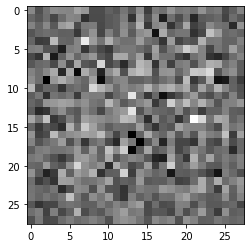

In [ ]:
random_noise = tf.random.normal([1, 100])
generated_noise = generator(random_noise, training=False)

plt.imshow(generated_noise[0, :, :, 0], cmap="gray");

## Create a GAN model
Now that we have built our separate Generator and Discriminator models, we can combine them in a single GAN model. We will use the same `keras.Sequential()` methodl except this time, instead of adding layers, we will add out models.

It is important to keep in mind that we have to set the Discriminator as untrainable in the GAN model, because Discriminator and Generator have to be trained separately. In the further steps, we will ssee how to implement it practically.

In [ ]:
def make_gan(generator, discriminator):
  discriminator.trainable = False
  model = keras.Sequential(name="GAN")

	# add generator
  model.add(generator)

	# add the discriminator
  model.add(discriminator)

	# compile model
  opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [ ]:
gan = make_gan(generator, discriminator)

gan.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 28, 28, 1)         1164289   
                                                                 
 Discriminator (Sequential)  (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


## Preparing to train the GAN algorithm
Building the Discriminator and the Generator networks is the easy part of building GAN. However, defining how exactly we want our model to train is much more challenging, and involves several steps:
1. Select a batch of real images
2. Use generator to create a batch of fake images
3. Send half of each batch to the discriminator, so it can decide which images are fake and which are real
4. Train the discriminator on that data
5. Train the generator based on the output of the discriminator and generate more believable fake images
6. Summarize the model performance and save the generated images


To help us organize all these steps, we can define a number of smaller functions and later combine it into one, breaking down the process.

### Load the real samples
* First, we need to start training the Discriminator with random real examples with label 1, which stands for "real." To do that, we have to load the images of our MNIST dataset. Since we will create our own labels (1) for all theese images, we don't need to load the labels, and we don't need the test dataset, and so we will leave them as blank `_`. 

* The images we load are 2D arrays that only denote width and height, however, CNN expect 3D arrays as input, which includes width, height, and number of color channels. We have to update the images to include the grayscale color channel. We can do that by using an `np.expand_dims()` function. It expands the shape of an input array that is passed to it. 

* Lastly, we need to normalize our pixel values to the range of [0,1].



In [ ]:
def load_real_samples():
	# load mnist dataset
	(train_images, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	real_images = np.expand_dims(train_images, axis=-1)
	# convert from unsigned ints to floats
	real_images = real_images.astype('float32')
	# scale from [0,255] to [0,1]
	real_images = real_images / 255.0
	return real_images

### Select random real samples
In order to train our discriminator well, we need to make sure that the discriminator recieves the samples in random order. We can achieve that by either shuffling the samples before each epoch, or by selecting random samples from the dataset. 

We will write a function that selects random images from the dataset and saves them as `x`, and also returns the labels `1`, to denote that these are real, and not generated, samples.

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	random_images = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	real_images = dataset[random_images]
	# generate 'real' class labels (1)
	real_labels = np.ones((n_samples, 1))
	return real_images, real_labels
 

### Generating fake images
As we mentioned earlier, for the generator to be able to generate fake images, we first need to give it some kind of input. Usually, it case of generators, the input is random noise. 
The first function, `generate_latent_points` will generate the random noise, and the second function, `generate_fake_samples`, will use the generated noise as a basis for a "prediction" to create fake images of numbers. We will also return the labels `0` for these fake generated samples. 

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	fake_images = generator.predict(x_input)
	# create 'fake' class labels (0)
	fake_labels = np.zeros((n_samples, 1))
	return fake_images, fake_labels


### Saving the generated images
Now that we have successfully completed writing the functions that will load our data, select random samples, generated noise, and train the generator, we want to make sure that we save the generated images.
To do this, we will plot several generated images by using `plt.subplot()`, and save them to the our working directory with `plt.savefig()`.

In the filename, we want to keep the number of the epoch at which the image w as generated. We can do that by adding `%03d` in the filename, and specifying that we want to have the number of epoch there by adding `% (epoch+1)` at the end.

In [ ]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = "generated_plot_e%03d.png" % (epoch+1)
	plt.savefig(filename)
	plt.close()

### Train and evaluate discriminator
Finally, before we can move on to writing our main training function, we need to train our discirminator and evaluate its perforomance.
This function will involve four steps:
* First, we will select real samples and real iamges by using our `generate_real_samples()` function, and train our **Dicriminator** on this data by calling `discriminator.evaluate()`.
* Second, we will generate fake images with our **Generator** by using the other function we wrote, `generate_fake_samples()`, and train the **Discriminator** using these freshly generated images.
* Third, we will pring the evaluation metrics.
* Fourth, we will save the image by using our function `save_plot()` and our Generator model with `generator.save()`.

In [ ]:
def summarize_performance(epoch, generator, discriminator, dataset, latent_dim, n_samples=100):
	# prepare real samples
	real_images, real_labels = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, accuracy_real = discriminator.evaluate(real_images, real_labels, verbose=0)
	# prepare fake examples
	fake_images, fake_labels = generate_fake_samples(generator, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, accuracy_fake = discriminator.evaluate(fake_images, fake_labels, verbose=0)
	# summarize discriminator performance
	print(">Detecting real: %.0f%%, detecting fake: %.0f%%" % (accuracy_real*100, accuracy_fake*100))
	# save plot
	save_plot(fake_images, epoch)
	# save the generator model tile file
	filename = "generator_model_%03d.h5" % (epoch + 1)
	generator.save(filename)

### Train the model
Now we are finally ready to write our final training function! 
* Specify how many batches will be trained during each epoch by dividing the overall number of the dataset by the size of the batch.
* Calculate the half of each batch.
* Loop over each epoch and over each iteration to:
 * Select real images from our dataset and take half of the batch using our function `generate_real_samples()`.
 * Generate fake images and take half of the batch using our function `generate_fake_samples()`.
 * Combine real half-batch and fake half-batch using `np.vstack()`, and passing it to the discriminator.
 * The disscriminator tries to decide, which images are fake, and which are real.
 * Prepare the latent points for the Generator in our GAN model by calling our function `generate_latent_points()`, and create the labels of (1).`1` labels are normally used for real images. However, as the Generator is trying to fool the Discriminator, it will pretend that its images are real by adding a fake real `1` label to the iamges it Generates. As a result, all the images, real and fake, that the discriminator receives, will have the "real" label `1`. And its job, then, is to recognize, which images are actually real (1), and which are fake (0).
 * Train GAN model calling `train_on_batch()` function.
 * Generate performance metrics and save the generated image and the generator model after each specified epoch in `if (i+1) % 1 == 0`. In this example, we save the image and the Generator model after every epoch. If we put `10` in `if (i+1) % 10 == 0`, we the function will save the image and the model after every 10 epochs.


In [ ]:
def train(generator, discriminator, gan, dataset, latent_dim, n_epochs=50, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# loop over epochs
	for epoch in range(n_epochs):
		# loop over the training set batches
		for batch in range(bat_per_epo):
			# get randomly selected 'real' samples
			real_images, real_labels = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			fake_images, fake_labels = generate_fake_samples(generator, latent_dim, half_batch)
			# create training set for the discriminator
			images, labels = np.vstack((real_images, fake_images)), np.vstack((real_labels, fake_labels))
			# update discriminator model weights
			d_loss, _ = discriminator.train_on_batch(images, labels)
			# prepare points in latent space as input for the generator
			images_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			labels_gan = np.ones((n_batch, 1))
			# update the generator
			g_loss = gan.train_on_batch(images_gan, labels_gan)
		if (i+1) % 1 == 0:
			print(">%d, %d/%d, d=%.3f, g=%.3f" % (epoch+1, batch+1, bat_per_epo, d_loss, g_loss))
			summarize_performance(epoch, generator, discriminator, dataset, latent_dim)
  

In [ ]:
discriminator = make_discriminator()
generator = make_generator(latent_dim)
gan = make_gan(generator, discriminator)
dataset = load_real_samples()
latent_dim = 100

As we trin the model, the discriminator loss is epxected to be aorund 0.5 to 0.8. If there is a sudden change in the discirminator loss, it indicates that the generator started making bad examples, which makes it very easy for the discirminator to discriminate between real and fake images.

In [ ]:
%%time
train(generator, discriminator, gan, dataset, latent_dim)

>1, 234/234, d=0.693, g=0.681
>Detecting real: 57%, detecting fake: 42%


>2, 234/234, d=0.629, g=0.789
>Detecting real: 70%, detecting fake: 93%


>3, 234/234, d=0.670, g=0.723
>Detecting real: 52%, detecting fake: 73%


>4, 234/234, d=0.689, g=0.723
>Detecting real: 36%, detecting fake: 79%


>5, 234/234, d=0.734, g=0.606
>Detecting real: 79%, detecting fake: 1%


>6, 234/234, d=0.712, g=0.628
>Detecting real: 76%, detecting fake: 9%


>7, 234/234, d=0.702, g=0.678
>Detecting real: 55%, detecting fake: 46%


>8, 234/234, d=0.690, g=0.706
>Detecting real: 56%, detecting fake: 71%


>9, 234/234, d=0.665, g=0.974
>Detecting real: 0%, detecting fake: 100%


>10, 234/234, d=0.679, g=0.720
>Detecting real: 56%, detecting fake: 74%


>11, 234/234, d=0.675, g=0.707
>Detecting real: 80%, detecting fake: 71%


>12, 234/234, d=0.678, g=0.757
>Detecting real: 38%, detecting fake: 97%


>13, 234/234, d=0.677, g=0.726
>Detecting real: 69%, detecting fake: 71%


>14, 234/234, d=0.690, g=0.708
>Detecting real: 73%, detecting fake: 73%


>15, 234/234, d=0.684, g=0.768
>Detecting real: 16%, detecting fake: 98%


>16, 234/234, d=0.693, g=0.700
>Detecting real: 75%, detecting fake: 44%


>17, 234/234, d=0.690, g=0.700
>Detecting real: 78%, detecting fake: 55%


>18, 234/234, d=0.682, g=0.742
>Detecting real: 27%, detecting fake: 95%


>19, 234/234, d=0.689, g=0.721
>Detecting real: 51%, detecting fake: 80%


>20, 234/234, d=0.685, g=0.654
>Detecting real: 100%, detecting fake: 0%


>21, 234/234, d=0.695, g=0.717
>Detecting real: 58%, detecting fake: 72%


>22, 234/234, d=0.689, g=0.647
>Detecting real: 100%, detecting fake: 2%


>23, 234/234, d=0.689, g=0.665
>Detecting real: 97%, detecting fake: 8%


>24, 234/234, d=0.684, g=0.712
>Detecting real: 74%, detecting fake: 81%


>25, 234/234, d=0.682, g=0.694
>Detecting real: 75%, detecting fake: 62%


>26, 234/234, d=0.684, g=0.711
>Detecting real: 50%, detecting fake: 87%


>27, 234/234, d=0.685, g=0.694
>Detecting real: 83%, detecting fake: 62%


>28, 234/234, d=0.686, g=0.678
>Detecting real: 98%, detecting fake: 19%


>29, 234/234, d=0.688, g=0.685
>Detecting real: 94%, detecting fake: 37%


>30, 234/234, d=0.688, g=0.706
>Detecting real: 66%, detecting fake: 72%


>31, 234/234, d=0.687, g=0.776
>Detecting real: 7%, detecting fake: 100%


>32, 234/234, d=0.687, g=0.692
>Detecting real: 89%, detecting fake: 31%


>33, 234/234, d=0.702, g=0.724
>Detecting real: 49%, detecting fake: 82%


>34, 234/234, d=0.689, g=0.801
>Detecting real: 2%, detecting fake: 100%


>35, 234/234, d=0.689, g=0.728
>Detecting real: 38%, detecting fake: 86%


>36, 234/234, d=0.684, g=0.702
>Detecting real: 68%, detecting fake: 69%


>37, 234/234, d=0.680, g=0.760
>Detecting real: 10%, detecting fake: 99%


>38, 234/234, d=0.685, g=0.679
>Detecting real: 99%, detecting fake: 5%


>39, 234/234, d=0.676, g=0.689
>Detecting real: 81%, detecting fake: 35%


>40, 234/234, d=0.685, g=0.725
>Detecting real: 29%, detecting fake: 94%


>41, 234/234, d=0.694, g=0.715
>Detecting real: 61%, detecting fake: 86%


>42, 234/234, d=0.687, g=0.703
>Detecting real: 67%, detecting fake: 76%


>43, 234/234, d=0.695, g=0.746
>Detecting real: 5%, detecting fake: 100%


>44, 234/234, d=0.683, g=0.694
>Detecting real: 69%, detecting fake: 68%


>45, 234/234, d=0.674, g=0.723
>Detecting real: 48%, detecting fake: 92%


>46, 234/234, d=0.684, g=0.673
>Detecting real: 91%, detecting fake: 31%


>47, 234/234, d=0.691, g=0.729
>Detecting real: 27%, detecting fake: 94%


>48, 234/234, d=0.693, g=0.707
>Detecting real: 48%, detecting fake: 72%


>49, 234/234, d=0.693, g=0.682
>Detecting real: 77%, detecting fake: 49%


>50, 234/234, d=0.690, g=0.704
>Detecting real: 47%, detecting fake: 75%


CPU times: user 23min 41s, sys: 39.3 s, total: 24min 20s
Wall time: 25min 15s


### Display generated images
Now that we have trained our model, let's take a look at some of the images it generated.
This time we will try using PIL library. 

In [ ]:
import PIL 
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('generated_plot_e{:03d}.png'.format(epoch_no))

For a more easy comparison, let's plot two images: the first image from the first epoch, and the second image from the last epoch of the training.

After 1 epochs:
After 50 epochs:


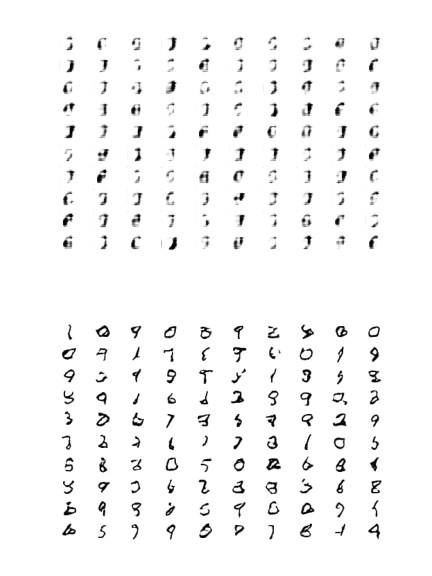

In [ ]:
epoch_nr_1 = 1
epoch_nr_2 = 50
img1 = display_image(epoch_nr_1)
img2 = display_image(epoch_nr_2)

def get_2_images(img1, img2):
    images = PIL.Image.new('RGB', (img1.width, img1.height + img2.height))
    print(f"After {epoch_nr_1} epochs:")
    images.paste(img1, (0, 0))
    print(f"After {epoch_nr_2} epochs:")
    images.paste(img2, (0, img1.height))
    return images

get_2_images(img1, img2)